In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from statsmodels.tsa.vector_ar.var_model import VAR
import math
from sklearn.metrics import mean_squared_error

dataframe = pd.read_csv ('C:/Users/ajay.gollapalli/Documents/Python Scripts/WHO-COVID-19-global-data_allcases.csv')
#dataframe = pd.read_csv ('C:/Users/ajay.gollapalli/Documents/Python Scripts/WHO-COVID-19-global-data.csv')
#dataframe = pd.read_csv ('C:/Users/ajay.gollapalli/Documents/Python Scripts/WHO-COVID-19-china.csv')
#dataframe = pd.read_csv ('C:/Users/ajay.gollapalli/Documents/Python Scripts/WHO-COVID-19-India.csv')
dataframe.head(4)

,Date_reported,Global,China,USA,India
0,1/11/2020,41,41,0,0
1,1/12/2020,0,0,0,0
2,1/13/2020,1,0,0,0
3,1/14/2020,1,0,0,0


In [2]:
import matplotlib.pyplot as plt
def fig_plot(dataframe,colnamex,colnamey,title):
    plt.title(title)
    plt.plot(dataframe[colnamex],dataframe[colnamey])
    plt.show()

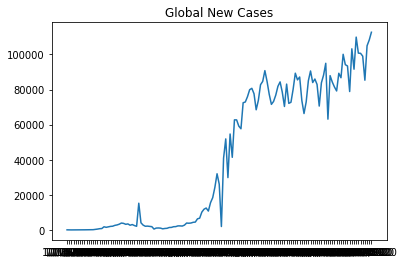

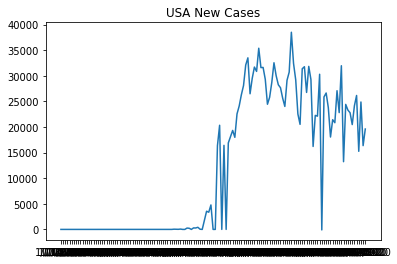

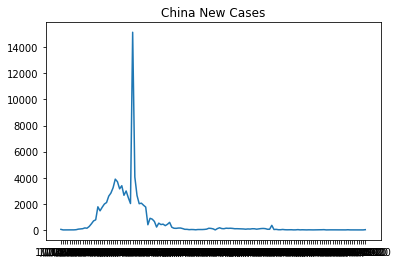

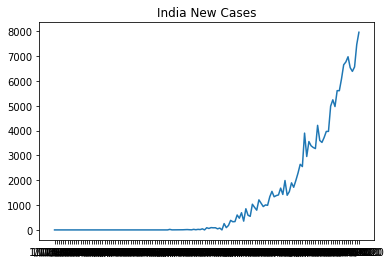

In [3]:
fig_plot(dataframe,"Date_reported","Global","Global New Cases")
fig_plot(dataframe,"Date_reported","USA","USA New Cases")
fig_plot(dataframe,"Date_reported","China","China New Cases")
fig_plot(dataframe,"Date_reported","India","India New Cases")


In [4]:
Initial_cases_global = dataframe["Global"].cumsum()
Initial_cases_USA = dataframe["USA"].cumsum()
Initial_cases_China = dataframe["China"].cumsum()
Initial_cases_India = dataframe["India"].cumsum()



0           41
1           41
2           42
3           43
4           43
        ...   
136    5406283
137    5491599
138    5596516
139    5704736
140    5817385
Name: Global, Length: 141, dtype: int64
0            0
1            0
2            0
3            0
4            0
        ...   
136    1618757
137    1634010
138    1658896
139    1675258
140    1694864
Name: USA, Length: 141, dtype: int64
0         41
1         41
2         41
3         41
4         41
       ...  
136    84543
137    84544
138    84547
139    84547
140    84565
Name: China, Length: 141, dtype: int64
0           0
1           0
2           0
3           0
4           0
        ...  
136    145380
137    151767
138    158333
139    165799
140    173763
Name: India, Length: 141, dtype: int64


In [5]:

dataframe['Date_reported']=pd.to_datetime(dataframe['Date_reported'])
dataframe.index = dataframe.Date_reported
dataframe = dataframe.drop(['Date_reported'],axis=1)



In [6]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [7]:
cointegration_test(dataframe)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Global ::  105.28    > 40.1749   =>   True
China  ::  47.82     > 24.2761   =>   True
USA    ::  3.45      > 12.3212   =>   False
India  ::  0.13      > 4.1296    =>   False


In [8]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 2): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [9]:
dataframe_differenced = dataframe.diff().dropna()
for name, column in dataframe_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

dataframe_differenced2 = dataframe_differenced.diff().dropna()
for name, column in dataframe_differenced2.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    cointegration_test(dataframe_differenced2)

    Augmented Dickey-Fuller Test on "Global" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.9769
 No. Lags Chosen       = 9
 Critical value 1% = -3.482
 Critical value 5% = -2.884
 Critical value 10% = -2.579
 => P-Value = 0.2968. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "China" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.3071
 No. Lags Chosen       = 3
 Critical value 1% = -3.479
 Critical value 5% = -2.883
 Critical value 10% = -2.578
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "USA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 

In [10]:
train = dataframe[:int(0.8*(len(dataframe)))]
valid = dataframe[int(0.8*(len(dataframe))):]
train.index = pd.DatetimeIndex(train.index.values)
#train = train.set_index('Date_reported')
train.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 112 entries, 2020-01-11 to 2020-05-01
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Global  112 non-null    int64
 1   China   112 non-null    int64
 2   USA     112 non-null    int64
 3   India   112 non-null    int64
dtypes: int64(4)
memory usage: 4.4 KB


In [11]:
dataframe_train_differenced = train.diff().dropna()
for name, column in dataframe_train_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    dataframe_train_differenced2 = dataframe_train_differenced.diff().dropna()
for name, column in dataframe_train_differenced2.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "Global" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.4451
 No. Lags Chosen       = 9
 Critical value 1% = -3.497
 Critical value 5% = -2.891
 Critical value 10% = -2.582
 => P-Value = 0.5605. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "China" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.2125
 No. Lags Chosen       = 3
 Critical value 1% = -3.493
 Critical value 5% = -2.889
 Critical value 10% = -2.581
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "USA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 

In [12]:
model =VAR(endog= train)
model_fit = model.fit(2)
model_fit.summary()


C:\Users\ajay.gollapalli\Anaconda3_1\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 03, Jun, 2020
Time:                     16:03:12
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    58.4123
Nobs:                     110.000    HQIC:                   57.8870
Log likelihood:          -3752.40    FPE:                9.65954e+24
AIC:                      57.5285    Det(Omega_mle):     7.05244e+24
--------------------------------------------------------------------
Results for equation Global
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const          1081.797454      1088.148867            0.994           0.320
L1.Global         0.858916         0.159029            5.401           0.000
L1.China         -0.579658         0.484798           -1.196           0.23

C:\Users\ajay.gollapalli\Anaconda3_1\lib\site-packages\statsmodels\base\wrapper.py:36: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


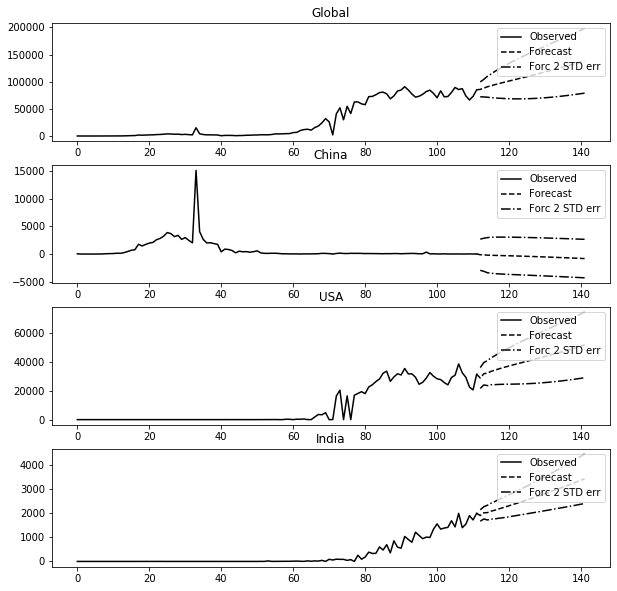

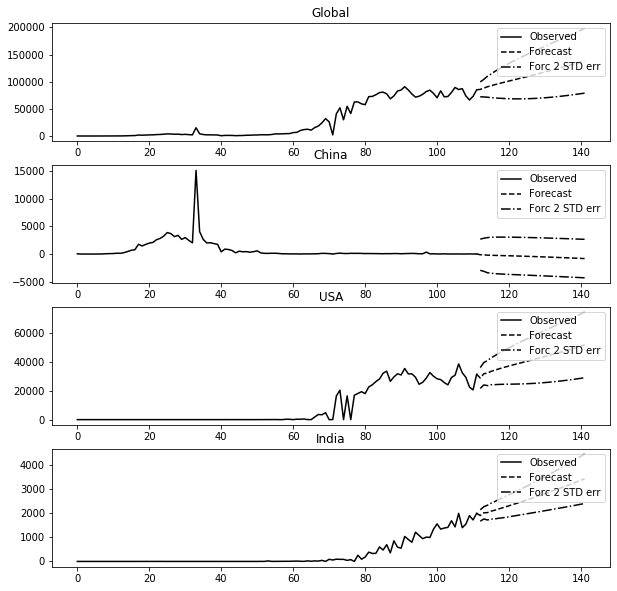

In [25]:
results = model_fit.forecast_interval(model_fit.y,steps=len(valid),alpha=0.1)
model_fit.plot_forecast(30)

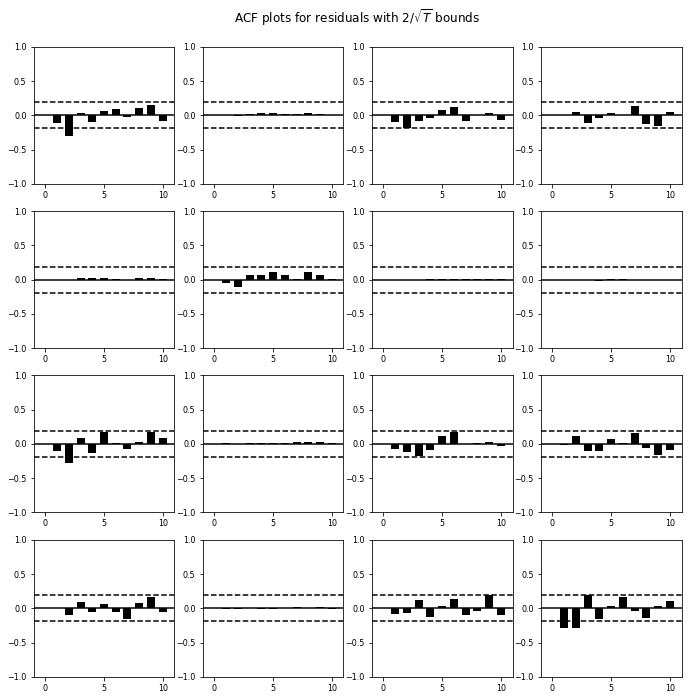

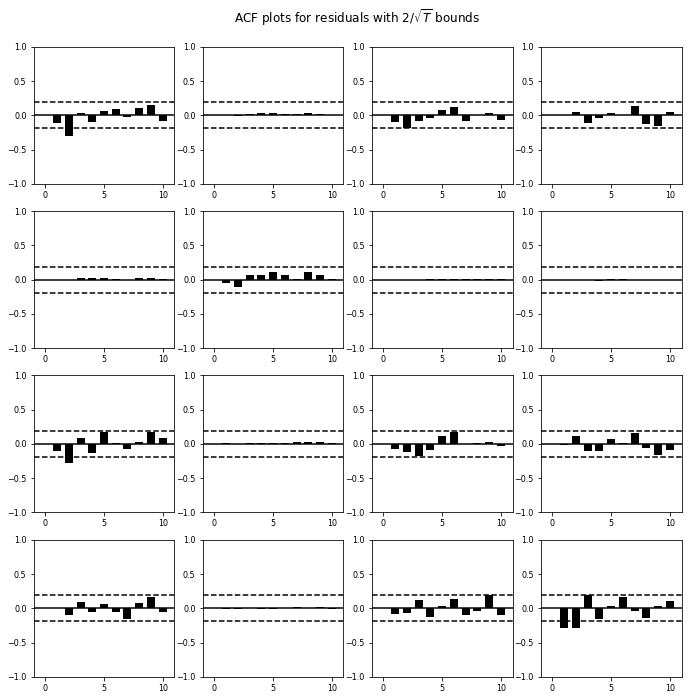

In [13]:
model_fit.plot_acorr()

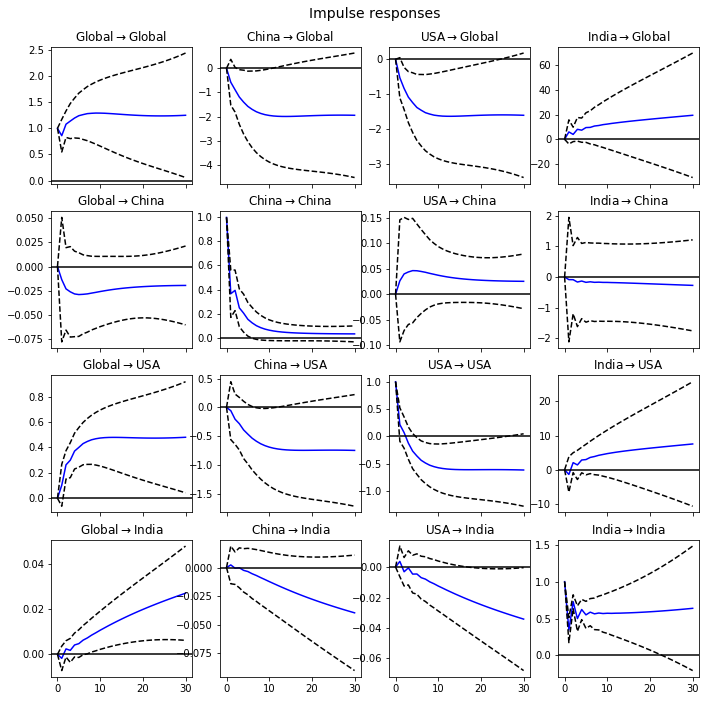

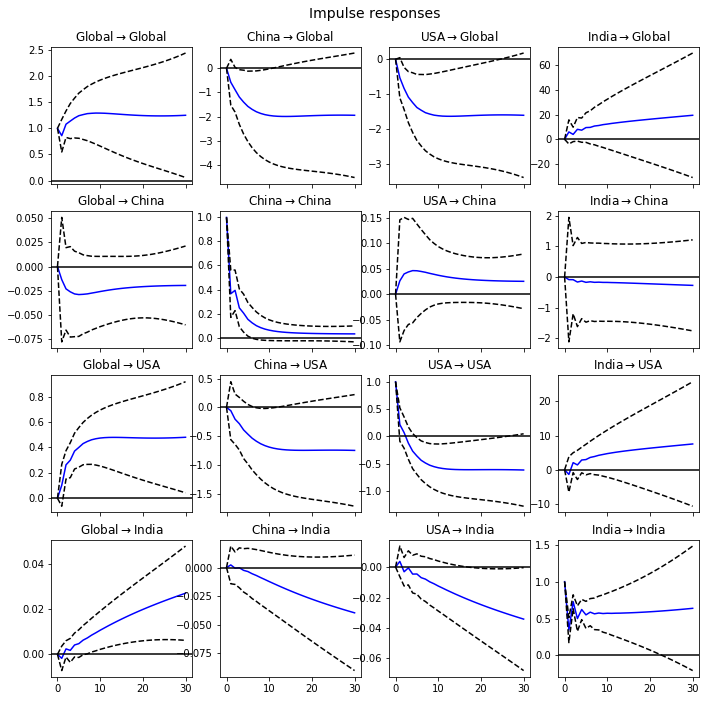

In [14]:
#check for impulse response
irf=model_fit.irf(30)
irf.plot(orth=False)

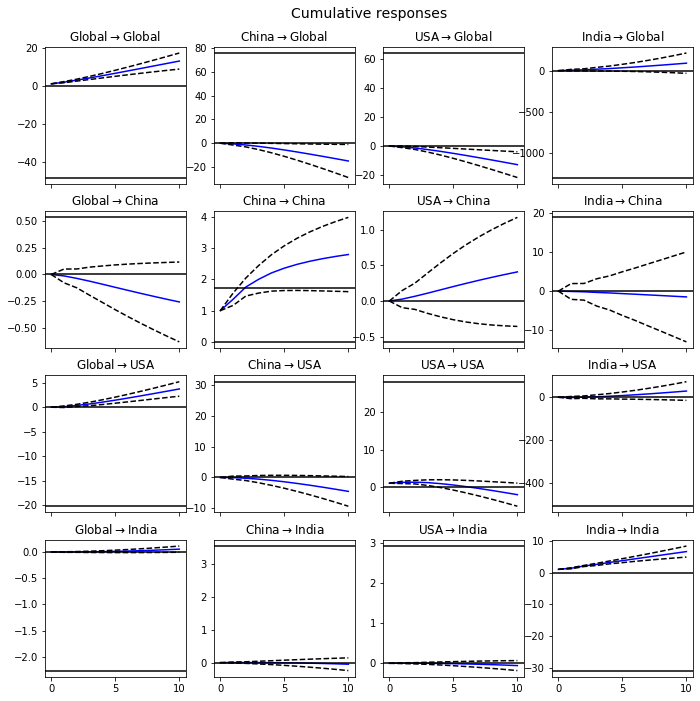

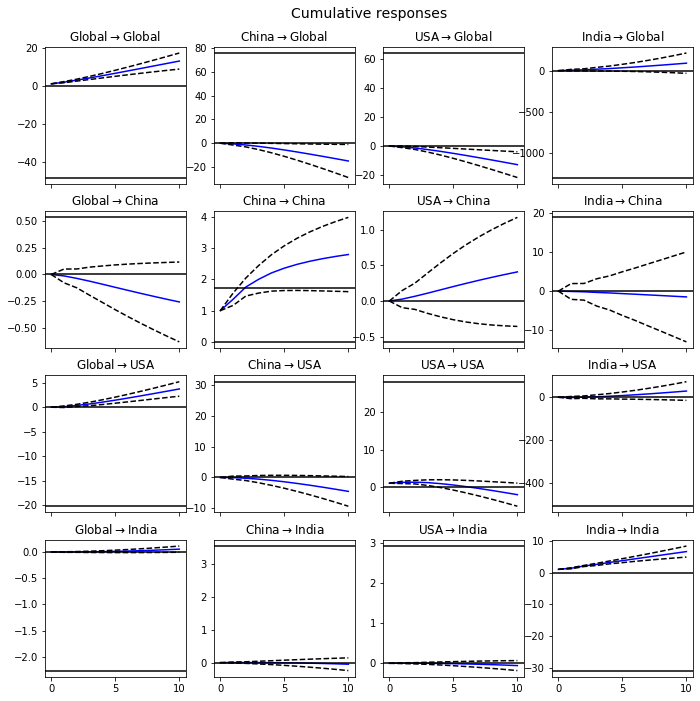

In [107]:
irf.plot_cum_effects(orth=False)

In [18]:
cols = dataframe.columns

pred=pd.DataFrame()
pred['New_cases_global'] = np.around([x[0] for x in results[1]],0)
pred['New_cases_global_lowerB'] = np.around([x[0] for x in results[0]],0)
pred['New_cases_global_upperB'] = np.around([x[0] for x in results[2]],0)

pred['New_cases_USA'] = np.around([x[1] for x in results[1]],0)
pred['New_cases_USA_lowerB'] = np.around([x[1] for x in results[0]],0)
pred['New_cases_USA_upperB'] = np.around([x[1] for x in results[2]],0)

pred['New_cases_China'] = np.around([x[2] for x in results[1]],0)
pred['New_cases_China_lowerB'] = np.around([x[2] for x in results[0]],0)
pred['New_cases_China_upperB'] = np.around([x[2] for x in results[2]],0)

pred['New_cases_India'] = np.around([x[3] for x in results[1]],0)
pred['New_cases_India_lowerB'] = np.around([x[3] for x in results[0]],0)
pred['New_cases_India_upperB'] = np.around([x[3] for x in results[2]],0)

pred["Cumulative_USA_Cases"] = pred["New_cases_USA"].cumsum() 
pred["Cumulative_Global_Cases"] = pred["New_cases_global"].cumsum()
pred["Cumulative_China_Cases"] = pred["New_cases_China"].cumsum()
pred["Cumulative_India_Cases"] = pred["New_cases_India"].cumsum()

pred.index= pd.date_range(start=dataframe.index[-1].date(),end=dataframe.index[-1].date()+timedelta(days=len(pred)),freq='D')[1:]


In [19]:
pred.head(4)



,New_cases_global,New_cases_global_lowerB,New_cases_global_upperB,New_cases_USA,New_cases_USA_lowerB,New_cases_USA_upperB,New_cases_China,New_cases_China_lowerB,New_cases_China_upperB,New_cases_India,New_cases_India_lowerB,New_cases_India_upperB,Cumulative_USA_Cases,Cumulative_Global_Cases,Cumulative_China_Cases,Cumulative_India_Cases
2020-05-31,74391.0,85835.0,97279.0,-2494.0,-124.0,2247.0,22717.0,28777.0,34837.0,1701.0,1900.0,2099.0,-2494.0,74391.0,22717.0,1701.0
2020-06-01,74501.0,88138.0,101776.0,-2654.0,-138.0,2378.0,25258.0,31744.0,38229.0,1801.0,2013.0,2225.0,-5148.0,148892.0,47975.0,3502.0
2020-06-02,74513.0,90675.0,106838.0,-2874.0,-203.0,2468.0,24904.0,32183.0,39462.0,1764.0,2020.0,2276.0,-8022.0,223405.0,72879.0,5266.0
2020-06-03,74043.0,92351.0,110659.0,-2942.0,-213.0,2517.0,25572.0,33371.0,41169.0,1807.0,2082.0,2357.0,-10964.0,297448.0,98451.0,7073.0
